In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
# Set plotting styles
sns.set(style="whitegrid")

# Ensure plots are displayed in the notebook
%matplotlib inline

In [3]:
file_path = '../data/Unemployment_Rate_upto_11_2020.xlsx'
unemployment_data = pd.read_excel(file_path)

# Display basic information about the dataset
print(unemployment_data.info())
print(unemployment_data.describe())

# Convert Date column to datetime
unemployment_data['Date'] = pd.to_datetime(unemployment_data['Date'], format='%d-%m-%Y')

# Drop redundant column
unemployment_data = unemployment_data.drop(columns=['Region.1'])

# Check for missing values
print(unemployment_data.isnull().sum())

# Display first few rows of the cleaned dataframe
print(unemployment_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267 entries, 0 to 266
Data columns (total 9 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Region                                   267 non-null    object 
 1   Date                                     267 non-null    object 
 2   Frequency                                267 non-null    object 
 3   Estimated Unemployment Rate (%)          267 non-null    float64
 4   Estimated Employed                       267 non-null    int64  
 5   Estimated Labour Participation Rate (%)  267 non-null    float64
 6   Region.1                                 267 non-null    object 
 7   Longitude                                267 non-null    float64
 8   Latitude                                 267 non-null    float64
dtypes: float64(4), int64(1), object(4)
memory usage: 18.9+ KB
None
       Estimated Unemployment Rate (%)  Estimated Employed

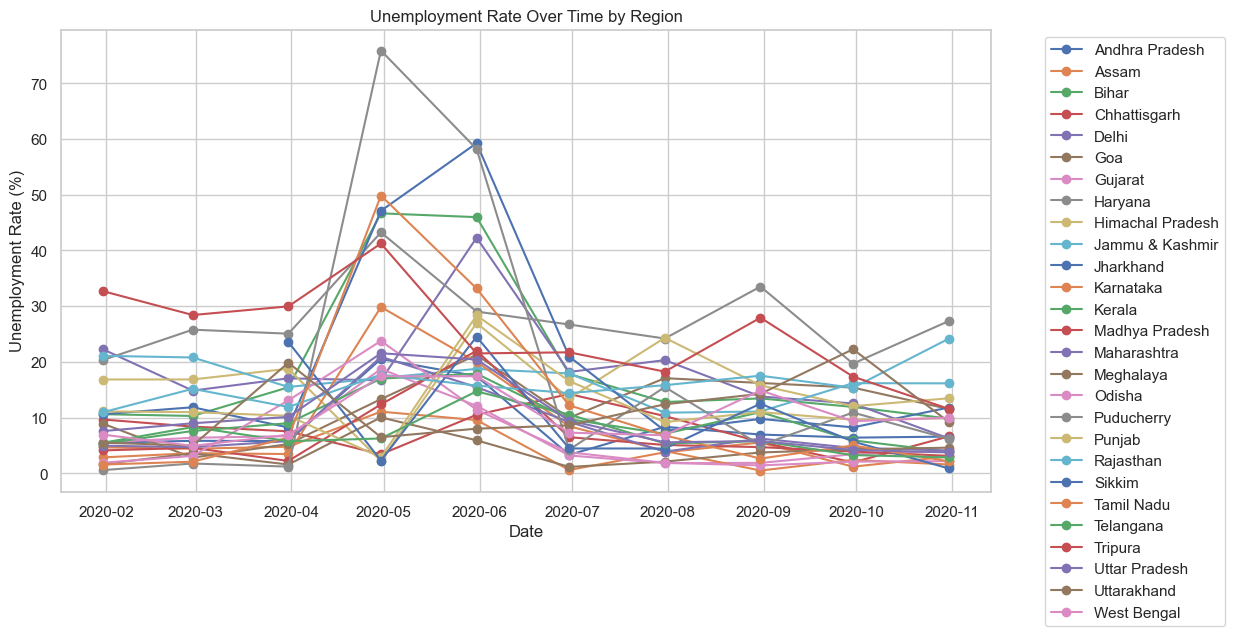

In [4]:
# Line plot of unemployment rate over time
plt.figure(figsize=(12, 6))
for region in unemployment_data['Region'].unique():
    region_data = unemployment_data[unemployment_data['Region'] == region]
    plt.plot(region_data['Date'], region_data['Estimated Unemployment Rate (%)'], marker='o', label=region)

plt.title('Unemployment Rate Over Time by Region')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

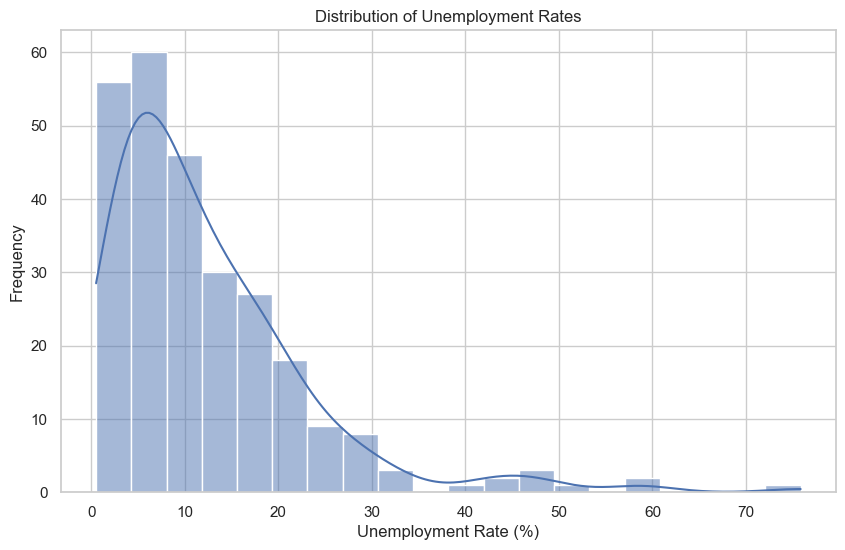

In [5]:
# Histogram of unemployment rates
plt.figure(figsize=(10, 6))
sns.histplot(unemployment_data['Estimated Unemployment Rate (%)'], bins=20, kde=True)
plt.title('Distribution of Unemployment Rates')
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Frequency')
plt.show()